In [1]:
#hide
#default_exp vis.lolp

# Loss of Load Probability

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections.abc import Iterable
from sklearn import linear_model

from ElexonDataPortal.api import Client

In [3]:
#exports
def get_latest_lolpdrm_df(api_key: str=None):
    start_date = pd.Timestamp.now(tz='Europe/London').strftime('%Y-%m-%d')
    end_date = pd.Timestamp.now(tz='Europe/London') + pd.Timedelta(days=3)

    client = Client(api_key=api_key)
    df_lolpdrm = client.get_LOLPDRM(start_date, end_date)

    return df_lolpdrm

In [4]:
df_lolpdrm = get_latest_lolpdrm_df()

df_lolpdrm.head()

,local_datetime,recordType,settlementDate,settlementPeriod,lolp12Forecast,drm12Forecast,lolp8HourForecast,drm8HourForecast,lolp4HourForecast,drm4HourForecast,lolp2HourForecast,drm2HourForecast,lolp1HourForecast,drm1HourForecast,activeFlag
0,2021-07-04 00:00:00+01:00,LOLPDRM,2021-07-04,1,0.000000000,13387.4510000,0.000000000,13858.7520000,0.000000000,13313.2880000,0.000000000,12255.3370000,0.000000000,12355.4650000,Y
1,2021-07-04 00:30:00+01:00,LOLPDRM,2021-07-04,2,0.000000000,14122.5970000,0.000000000,14596.8740000,0.000000000,13856.6750000,0.000000000,12930.5380000,0.000000000,12886.8910000,Y
2,2021-07-04 01:00:00+01:00,LOLPDRM,2021-07-04,3,0.000000000,14476.4020000,0.000000000,14992.3510000,0.000000000,14408.7820000,0.000000000,13264.6930000,0.000000000,13237.9100000,Y
3,2021-07-04 01:30:00+01:00,LOLPDRM,2021-07-04,4,0.000000000,14923.7680000,0.000000000,15439.7160000,0.000000000,14677.1020000,0.000000000,13510.1410000,0.000000000,13510.1410000,Y
4,2021-07-04 02:00:00+01:00,LOLPDRM,2021-07-04,5,0.000000000,15018.7850000,0.000000000,15310.3220000,0.000000000,13561.4560000,0.000000000,13602.5470000,0.000000000,13602.5470000,Y


<br>

N.b. The 12:00 forecast is made every day at mid-day and overwites the previous values, the 8/4/2/1 hour forecasts are not over-written

In [5]:
#exports
def clean_fcst_df(
    df_lolpdrm: pd.DataFrame,
    fcst_type: str='lolp',
    fcst_horizons: list=[8, 4, 2, 1]
):
    cols_renaming_map = {f'{fcst_type}12Forecast': '12:00'}

    cols_renaming_map.update({
        f'{fcst_type}{fcst_horizon}HourForecast': f"{fcst_horizon} Hour{'s' if fcst_horizon>1 else ''} Ahead" 
        for fcst_horizon 
        in fcst_horizons
    })

    df_clean_fcst = (df_lolpdrm
                     .set_index('local_datetime')
                     [cols_renaming_map.keys()]
                     .rename(columns=cols_renaming_map)
                     .astype(float)
                    )

    return df_clean_fcst

In [6]:
df_clean_lolp = clean_fcst_df(df_lolpdrm)

df_clean_lolp.head()

,12:00,8 Hours Ahead,4 Hours Ahead,2 Hours Ahead,1 Hour Ahead
local_datetime,,,,,
2021-07-04 00:00:00+01:00,0.0,0.0,0.0,0.0,0.0
2021-07-04 00:30:00+01:00,0.0,0.0,0.0,0.0,0.0
2021-07-04 01:00:00+01:00,0.0,0.0,0.0,0.0,0.0
2021-07-04 01:30:00+01:00,0.0,0.0,0.0,0.0,0.0
2021-07-04 02:00:00+01:00,0.0,0.0,0.0,0.0,0.0


In [7]:
df_clean_drm = clean_fcst_df(df_lolpdrm, 'drm')

df_clean_drm.head()

,12:00,8 Hours Ahead,4 Hours Ahead,2 Hours Ahead,1 Hour Ahead
local_datetime,,,,,
2021-07-04 00:00:00+01:00,13387.451,13858.752,13313.288,12255.337,12355.465
2021-07-04 00:30:00+01:00,14122.597,14596.874,13856.675,12930.538,12886.891
2021-07-04 01:00:00+01:00,14476.402,14992.351,14408.782,13264.693,13237.910
2021-07-04 01:30:00+01:00,14923.768,15439.716,14677.102,13510.141,13510.141
2021-07-04 02:00:00+01:00,15018.785,15310.322,13561.456,13602.547,13602.547


<AxesSubplot:xlabel='local_datetime'>

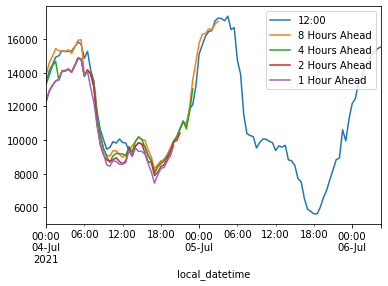

In [8]:
df_clean_drm.plot()

In [9]:
#exports
class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

In [31]:
#exports
def create_fcst_htmp(
    df_clean: pd.DataFrame,
    img_fp: str='docs/img/vis/drm_fcst_htmp.png'
):
    # Plotting
    fig, ax = plt.subplots(dpi=250)

    htmp = sns.heatmap(df_clean, vmin=0, ax=ax)

    set_date_ticks(ax, df_clean.index.min(), df_clean.index.max(), freq='6H', date_format='%Y-%m-%d %H:%M')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25) 
    ax.xaxis.tick_top()
    ax.set_ylabel('')
    cbar = htmp.collections[0].colorbar
    cbar.set_label('De-Rated Margin (MW)', labelpad=20, rotation=270)
    
    # Saving
    fig.tight_layout()
    fig.savefig(img_fp)

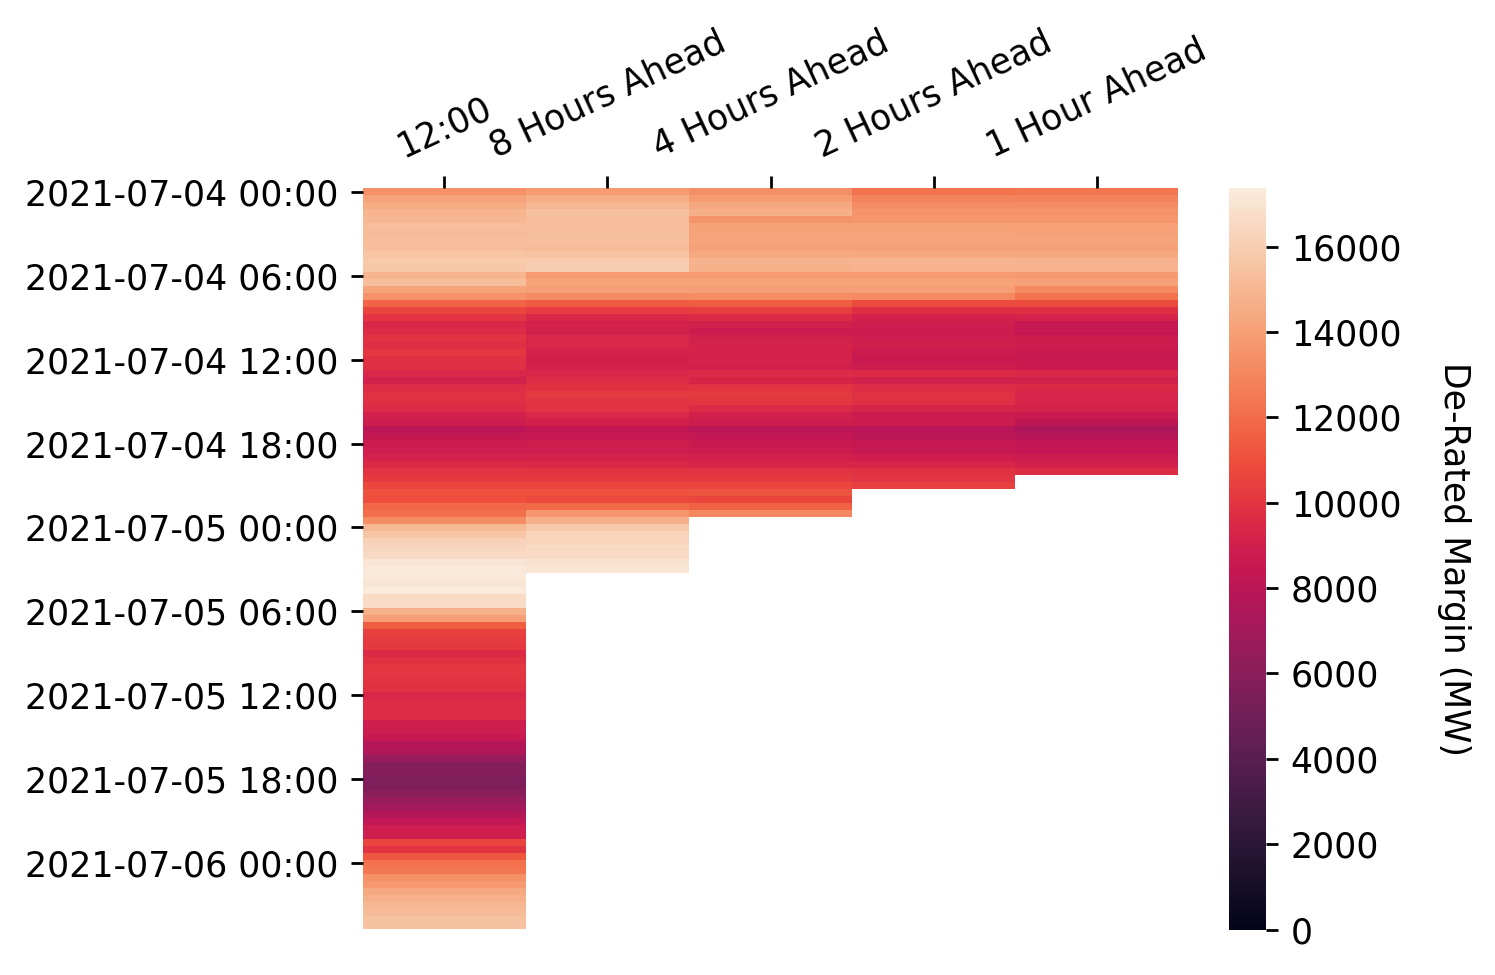

In [32]:
create_fcst_htmp(df_clean_drm, img_fp='../docs/img/vis/drm_fcst_htmp.png')

In [12]:
#exports
def create_fcst_delta_htmp(
    df_clean_drm: pd.DataFrame,
    img_fp: str='docs/img/vis/drm_fcst_delta_htmp.png'
):
    # Preparing data
    df_drm_delta = df_clean_drm.iloc[:, 2:].apply(lambda col: col-df_clean_drm.iloc[:, 1]).dropna(how='all', axis=1).dropna(how='all')

    # Plotting
    fig, ax = plt.subplots(dpi=150)

    htmp = sns.heatmap(df_drm_delta, center=0, cmap='bwr_r', ax=ax)

    set_date_ticks(ax, df_drm_delta.index.min(), df_drm_delta.index.max(), freq='3H', date_format='%Y-%m-%d %H:%M')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25) 
    ax.xaxis.tick_top()
    ax.set_ylabel('')
    cbar = htmp.collections[0].colorbar
    cbar.set_label('Delta to the 8 Hour-\nAhead Forecast Horizon', labelpad=25, rotation=270)

    # Saving
    fig.tight_layout()
    fig.savefig(img_fp)

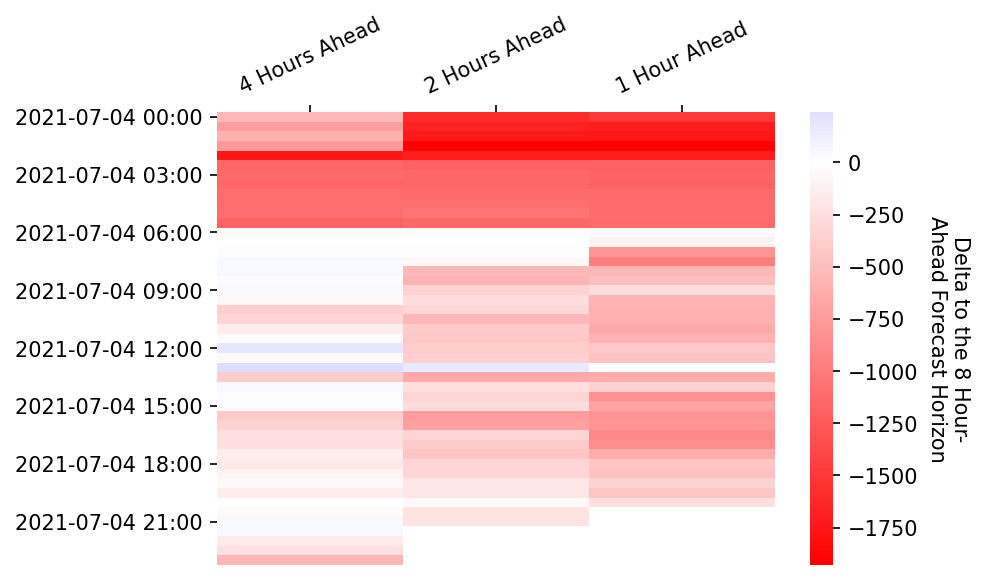

In [13]:
create_fcst_delta_htmp(df_clean_drm, img_fp='../docs/img/vis/drm_fcst_delta_htmp.png')

In [14]:
#exports
def save_lolpdrm_imgs(
    docs_dir: str='docs',
    api_key: str=None,
    fcst_type: str='lolp',
    fcst_horizons: list=[8, 4, 2, 1]
):
    df_lolpdrm = get_latest_lolpdrm_df(api_key=api_key)
    df_clean = clean_fcst_df(df_lolpdrm, fcst_type=fcst_type, fcst_horizons=fcst_horizons)
    
    create_fcst_htmp(df_clean, img_fp=f'{docs_dir}/img/vis/{fcst_type}_fcst_htmp.png')
    plt.close()
    
    create_fcst_delta_htmp(df_clean, img_fp=f'{docs_dir}/img/vis/{fcst_type}_fcst_delta_htmp.png')
    plt.close()

In [15]:
save_lolpdrm_imgs(docs_dir='../docs', fcst_type='drm')

In [29]:
#exports
def construct_drm_md_txt(
    update_time: str=None
):
    if update_time is None:
        update_time = pd.Timestamp.now().round('5min').strftime('%Y-%m-%d %H:%M')
        
    md_txt = f"""### De-Rated Margin
    
In each settlement period the system operator publishes the de-rated margin forecast calculated in accordance with the [Loss of Load Probability Calculation Statement](https://www.elexon.co.uk/documents/bsc-codes/lolp/loss-of-load-probability-calculation-statement/) at the following times:

* At 1200 hours on each calendar day for all Settlement Periods for which Gate Closure has not yet passed and which occur within the current Operational Day or the following Operational Day; and
* At eight, four, two and one hour(s) prior to the beginning of the Settlement Period to which the De-Rated Margin Forecast relates.

These figures will be updated on an hourly basis, the last update was at: {update_time}
    
<br>

#### Forecasts

The following heatmap shows the evolving de-rated margin forecast across the different forecast horizons.

![](img/vis/drm_fcst_htmp.png)
    
<br>

#### Forecast Deltas

The following heatmap shows how the more recent de-rated margin forecasts deviate from the 8 hours ahead forecast.

![](img/vis/drm_fcst_delta_htmp.png)
"""
    
    return md_txt

In [26]:
#exports
def generate_lolpdrm_imgs_text(
    docs_dir: str='docs',
    api_key: str=None,
    fcst_horizons: list=[8, 4, 2, 1],
    update_time: str=None
):
    for fcst_type in ['drm', 'lolp']:
        save_lolpdrm_imgs(docs_dir=docs_dir, api_key=api_key, fcst_type=fcst_type, fcst_horizons=fcst_horizons)
        
    md_txt = construct_drm_md_txt(update_time=update_time)
    
    return md_txt

In [27]:
md_txt = generate_lolpdrm_imgs_text('../docs')

print(md_txt)

### De-Rated Margin
    
In each settlement period the system operator publishes the de-rated margin forecast calculated in accordance with the [Loss of Load Probability Calculation Statement](https://www.elexon.co.uk/documents/bsc-codes/lolp/loss-of-load-probability-calculation-statement/) at the following times:

* At 1200 hours on each calendar day for all Settlement Periods for which Gate Closure has not yet passed and which occur within the current Operational Day or the following Operational Day; and
* At eight, four, two and one hour(s) prior to the beginning of the Settlement Period to which the De-Rated Margin Forecast relates.

These figures will be updated on an hourly basis, the last update was at: 2021-07-04 19:35
    
<br>

#### Forecasts

The following heatmap shows the evolving de-rated margin forecast across the different forecast horizons.

![](docs/img/vis/drm_fcst_htmp.png)
    
<br>

#### Forecast Deltas

The following heatmap shows the how the more recent de-rated

In [34]:
#hide
from ElexonDataPortal.dev.nbdev import notebook2script
notebook2script('vis-03-lolp.ipynb')

Converted vis-03-lolp.ipynb.
